In [2]:
FOOOF?

# Topographies

In [1]:
import csv

import numpy as np
from numpy.linalg import LinAlgError

import pandas as pd
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar, rcParams

import mne

from fooof import FOOOF, FOOOFGroup

import sys
sys.path.append('../bratios')
from ratios import *

In [6]:
# Open CSV
data = pd.read_csv("../dat/MIPDB_PublicFile.csv")

In [7]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../dat/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

# Create the info structure needed by MNE
info = mne.create_info(ch_labels, 500, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(np.zeros([111, 1]), info, verbose=False)

In [8]:
def get_real_params(df, chs, age=[0,100]):


    age_range = df[(df['Age'] >= age[0]) & (df['Age'] <= age[1])]
    age_range_ids = age_range.ID.values
    
    #Open Eyes closed data for all IDs
    problem_files = []
    missing_files = []
    peaks = []
    apcs = []
    tb_ratios = []
    ages = []
    
    for filename in age_range_ids:
        try:
    
            # Construct FOOOFGroup model on psd
            curr = np.load('../dat/psds/'+ filename + '_ec_psds.npz')
            freqs = curr['arr_0']
            
            fg = FOOOFGroup(verbose=False)
            fg.fit(freqs, curr['arr_1'][0])
            apcs.append(fg.get_all_data('aperiodic_params', 'exponent'))
            tb_ratios.append([calc_band_ratio(freqs, ps, THETA_BAND, BETA_BAND) for ps in curr['arr_1'][0]])
            ages.append(data[data['ID'] ==filename].Age.values[0])
                
        except FileNotFoundError:
            missing_files.append(filename)
        except ValueError:
            problem_files.append(filename)
        except LinAlgError:
            problem_files.append(filename)

    return [tb_ratios, apcs, ages], [problem_files, missing_files]

In [9]:
# Extract data
datas, f_stuff = get_real_params(dat_df, chs=list(range(111)))
ratios, exps, ages = datas

In [10]:
# Calculate average values across locations
avg_ratios = np.array(ratios).mean(0)
avg_exps = np.array(exps).mean(0)

In [11]:
# Calculate correlation between spatial topographies
print(spearmanr(avg_ratios, avg_exps))

SpearmanrResult(correlation=0.7287908037908037, pvalue=1.2254410566233577e-19)


In [12]:
# Check data ranges
print('Ratios\t {:1.3f} - {:1.3f}'.format(min(avg_ratios), max(avg_ratios)))
print('Exps  \t {:1.3f} - {:1.3f}'.format(min(avg_exps), max(avg_exps)))

Ratios	 8.586 - 10.427
Exps  	 1.558 - 1.754


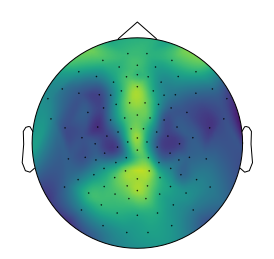

In [13]:
# Plot average ratio values
fig, ax = plt.subplots();
mne.viz.plot_topomap(avg_ratios, raw.info, vmin=8.25, vmax=10.75, cmap=cm.viridis, contours=0, axes=ax);
fig.savefig('../figures/RatiosTopo.png', dpi=700);

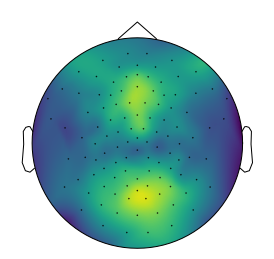

In [14]:
# Plot average exponent values values
fig, ax = plt.subplots();
mne.viz.plot_topomap(avg_exps, raw.info, vmin=1.5, vmax=1.77, cmap=cm.viridis, contours=0, axes=ax);
fig.savefig('../figures/ExpsTopo.png', dpi=700);